In [1]:
# https://cds.climate.copernicus.eu/api-how-to
# Import library for CDS data access and load credentials
import os
import numpy as np
from osgeo import ogr, osr, gdal
import cdsapi
c = cdsapi.Client()

# Upland burn modules
import utils.extract_aoi as extract
import utils.plot_data as plotd
import utils.functions as functions
from utils.get_configuration import get_configuration

# Define input variables if not calling externally
try:
    print("Input dataset from: {}".format(basefolder))     # check if defined

# if not defined raises an error and control shifts to except block. 
except:
    print ("Defining variables as not called externally") 
    
    # Get configuration information
    basefolder, s1ardfolder, datasets, outfolder, tmpfolder, ofiles, hdfile, pfile, verbose, graphics = get_configuration(skye=True)
    
    # Burn Polygon
    polygon = "Skye_burn_extent_163"
    
    # Whether to plot the graph
    graphics = True


Defining variables as not called externally
Loaded configuration: {'sharedfolder': 'my_shared_data_folder'}.


In [2]:
# Specify site to extract
import geojson as gj

# WGS84 projection reference
OSR_WGS84 = osr.SpatialReference()
OSR_WGS84.ImportFromEPSG(4326)
OSR_OSGB36 = osr.SpatialReference()
OSR_OSGB36.ImportFromEPSG(27700)

# Setup burn area polygon
polygon_file = os.path.join(datasets, polygon + ".geojson")

# Get coords for bounding box
with open (polygon_file, 'r') as f:
    loadg = gj.loads(f.read())
x, y = zip(*gj.utils.coords(loadg))
del loadg
min_x, max_x, min_y, max_y = min(x), max(x), min(y), max(y)
if verbose:
    print("Input for GeoJSON ULeft {:.3f}:{:.3f} LRight {:.3f}:{:.3f} ".format(min_x, max_y, max_x, min_y))

# Transform to WGS84
to_wgs84 = osr.CoordinateTransformation(OSR_OSGB36, OSR_WGS84)
xymin = to_wgs84.TransformPoint(min_x, min_y)
xymax = to_wgs84.TransformPoint(max_x, max_y)
offset = 0.5 # degrees
sitell = [xymax[1]+offset, xymin[0]-offset, xymin[1]-offset, xymax[0]+offset]
if verbose:
    print("WGS84 ULeft {:.3f}:{:.3f} LRight {:.3f}:{:.3f} ".format(xymin[0], xymax[1], xymax[0], xymin[1]))

# Years and months to download and plot
years = ['2019']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
num_days = functions.numberOfDays(int(years[0]), int(months[0]))
days = list(range(1, num_days+1, 1))
if verbose:
    print("Number of days: ", num_days, days)  

# Variables
variables = [
            '10m_u_component_of_wind', '10m_v_component_of_wind', 'leaf_area_index_high_vegetation',
            'leaf_area_index_low_vegetation', 'snow_cover', 'surface_pressure',
            'surface_runoff', 'surface_solar_radiation_downwards', 'total_precipitation',
        ]
ecmwf_names = [
            'u10', 'v10', 'lai_hv', 'lai_lv', 'snowc', 'sp', 'sro', 'ssrd', 'tp',
        ]
numvariables = len(variables)

In [3]:
# Defined output path
outfile = polygon + '-download.nc'
outnc = os.path.join(tmpfolder,outfile)
keep = True
if not keep and os.path.exists(outnc):
    os.remove(outnc)

In [4]:
# Retieve needed data
if not os.path.exists(outnc):
    print("Downloading: ",outnc)
    c.retrieve(
        'reanalysis-era5-land',
        {
            'format': 'netcdf',
            'product_type': 'monthly_averaged_reanalysis',
            'variable': variables,
            'year': years,
            'month': months,
            'day': days,
            'time': '00:00',
            'area': sitell,
        },
        outnc)
else:
    print("Already downloaded: {} ".format(outnc))

Already downloaded: /home/slavender/temp/Skye_burn_extent_163-download.nc 


In [5]:
# Load NetCDF
import netCDF4
from datetime import datetime, timezone

file = netCDF4.Dataset(outnc)
print("Loading: {}  ".format(file.variables.keys()))

# Extract times
times = file.variables['time']
dt = [netCDF4.num2date(ts, units=times.units).strftime('%d%b%y') for ts in times[:]]
dt_num = [netCDF4.num2date(ts, units=times.units).strftime('%Y%m%d') for ts in times[:]]
timesteps = len(dt)
if verbose:
    print("Time steps {} times {}".format(timesteps,dt[0:5]))

# Reformat the variables
mean_parameters = np.zeros((timesteps,numvariables), dtype=float)
std_parameters = np.zeros((timesteps,numvariables), dtype=float)

numyears = 0.0
for num in range(int(numvariables)):
    parameter = file.variables[ecmwf_names[num]] # physical variable
    if verbose:
        print("{}: {} {}".format(ecmwf_names[num],parameter.shape,mean_parameters.shape))
    for month in range(365):
        # Set null values to zero
        parameter[month,:,:][parameter[month,:,:] < (-32766.000)] = np.nan
        mean_parameters[month,num] = np.nanmean(parameter[month,:,:])
        std_parameters[month,num] = np.nanstd(parameter[month,:,:])
    if verbose:
        print("{}: {} min {:.3f} max {:.3f}".format(num, ecmwf_names[num],np.nanmin(mean_parameters[:,num]),np.nanmax(mean_parameters[:,num])))
    
print("Extracted data shape: ", mean_parameters.shape) 

# Clear arrays
file = None
del parameter

Loading: odict_keys(['longitude', 'latitude', 'time', 'u10', 'v10', 'lai_hv', 'lai_lv', 'snowc', 'sp', 'sro', 'ssrd', 'tp'])  
Extracted data shape:  (365, 9)


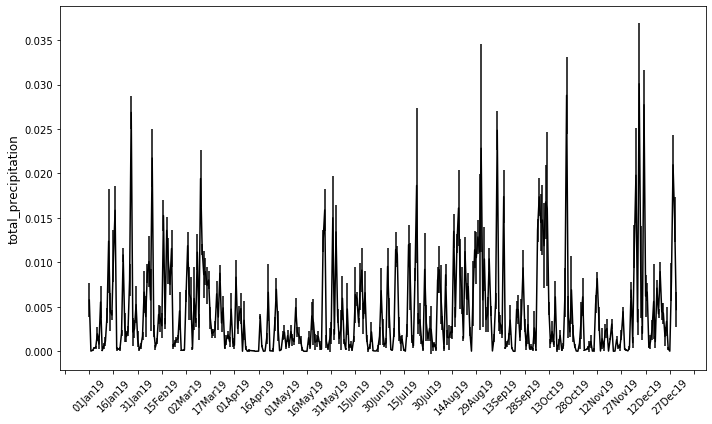

In [6]:
import matplotlib.pyplot as plt
plt.set_loglevel("critical")

if graphics:
    # Plot time-series
    outfile = os.path.join(outfolder,"era-plot.png")
    prodnum = 8 # precipitation
    # print("Plotting {} for {}".format(ecmwf_names[prodnum],dt))
    plotd.plot_line(dt, mean_parameters[:,prodnum], std_parameters[:,prodnum], variables[prodnum], outfile)